# Introdução ao Theano

Theano é uma biblioteca de computação simbólica, que possui várias funcionalidades que facilitam o treinamento de redes neurais (e outros modelos de Aprendizagem de Máquina): implementação de várias funcões de álgebra linear; execução em CPU ou GPU de forma transparente e, principamente, diferenciação automática (descrita abaixo)

Nessa biblioteca, cálculos são expressos como um grafo de computação. Por exemplo, vamos criar duas varíaveis escalares: a e b:

In [4]:
import theano
from theano import tensor as T

a = T.scalar()
b = T.scalar()

Vamos definir c como a soma de a e b. O resultado é uma outra variável simbólica:

In [5]:
c = a + b
type(c)

theano.tensor.var.TensorVariable

Isto é, ao somar duas variáveis, não estamos imediatamente calculando o valor da soma, e sim construindo um grafo que descreve a função:

![](images/simple_graph.svg)

Para executar esse cálculo, precisamos primeiro compilar uma função. A sintaxe é a seguinte:

```
f = theano.function([lista_de_entradas], saida)
```

onde o primeiro argumento é uma lista de entradas da função (variáveis que são usadas para computar o resultado), e o segundo argumento é a variável (ou lista de variáveis) de saída.

In [6]:
soma = theano.function([a,b],c)

In [7]:
soma(2,3)

array(5.0, dtype=float32)

Uma forma alternativa para obter o resultado de uma expressão é usar a função eval, que imediatamente compila a função e a chama com os argumentos fornecidos (útil para Debug):

```
resultado = saida.eval({entrada1: valor, entrada2: valor})
```

onde **saida** é a variável simbólica que queremos computar, **entrada1/2** são as variáveis simbólicas de entrada, e **valor** são os valores assinalados para a variável

In [8]:
c.eval({a: 2, b: 3})

array(5.0, dtype=float32)

## Variáveis compartilhadas (Shared Variables)

Variáveis compartilhadas do Theano se comportam como variáveis simbólicas (podendo ser usadas em expressões simbólicas), e também como variáveis normais do Python (possuindo um "estado" permanente). 

Esse tipo de variável é muito útil para modelos de aprendizagem de máquina, onde queremos variáveis que mantenham um estado entre chamadas diferentes (por exemplo, os pesos de um modelo).

Por exemplo, considere um modelo linear, que computa a saída $y(x) = \textbf{w}^\intercal \textbf{x}$, isto é, o produto entre os vetores w e x. 



Para criarmos uma variável compartilhada, usamos a seguinte função:

```
variavel = theano.shared(valor_inicial)
```
Por exemplo, vamos iniciar a variável $w$ com um vetor de duas posições: $[1, 0.5]$

In [9]:
import numpy as np 
w_inicial = np.array([1., 0.5])

w = theano.shared(w_inicial)
print type(w)

<class 'theano.tensor.sharedvar.TensorSharedVariable'>


Podemos ver que $w$ é uma variável simbólica, mas podemos obter seu valor usando a função:

```
variavel.get_value()
```

De forma similar, podemos atualizar seu valor utilizando:

```
variavel.set_value(novo_valor)
```

In [10]:
print('valor anterior: %s' % w.get_value())

w.set_value([2, 0.5])
print ('Novo valor: %s' % w.get_value())

valor anterior: [ 1.   0.5]
Novo valor: [ 2.   0.5]


O exemplo acima mostra que a variável compartilhada pode ser usada como uma variável normal em Python (mantendo um estado).

O exemplo abaixo mostra como podemos usá-la em uma expressão simbólica:

In [11]:
x = T.vector()
y = w.dot(x)    # a função dot implementa produto interno de vetores (e também matrizes)

f = theano.function([x], y)

In [12]:
print(f([5,6]))

13.0


Onde o resultado usa o valor atual da variável $w$: $5 \times 2 + 6 \times 0.5 = 13$.

Note que para compilarmos a função f, informamos apenas $x$ como entrada. Isto é, não precisamos informar as variáveis compartilhadas durante a compilação/chamada da função, visto que a variável mantém um estado.

### Exercício

Implemente uma função que calcule $y(x) = ax + b$, onde $a$ e $b$ são variáveis compartilhadas, que começam com o valor 3 e 1, respectivamente. Compile a função para calcular esse valor, e execute com o valor de $x = 5$.

Nota: nesse exercício, todas as variáveis são escalares (use T.scalar() para a variável x)

Nota 2: Esse [Link](http://www.deeplearning.net/software/theano/library/tensor/basic.html) contém a descrição das funcionalidades básicas do Theano

In [13]:
#Sua solução:

In [ ]:
#Execute essa célula para ver a solução

%load solutions/theano_shared.py

## Diferenciação automática

A grande vantagem de usar variáveis simbólicas é que isso permite diferenciação automática. 
Em vários problemas de Machine Learning, precisamos calcular a derivada parcial de uma função de custo, com relação a cada um dos parâmetros do modelo. Ao definir a função de custo como um grafo de operações, Theano pode então usar a regra da cadeia para automaticamente calcular tais derivadas.

### Exemplo prático

Consideremos a seguinte equação:

$$c = a^2 + 3b$$

Podemos usar o método T.grad para calcular as derivadas parciais $\frac{\delta c}{\delta a}$ e $\frac{\delta c}{\delta b}$

A sintaxe do comando é:

```
dy_dx = T.grad(y, x)
```

Onde **y** é uma variável simbólica que representa a expressão a ser diferenciada, e **x** é a entrada. O resultado é outra variável simbólica, que contém a expressão para calcular $\frac{\delta y}{\delta x}$

In [15]:
c = T.pow(a,2) + 3 * b  # c = a^2 + 3b

In [16]:
dc_da = T.grad(c, a)
dc_db = T.grad(c, b)

Podemos agora criar uma função que retorna o valor das derivadas para dados valores de **a** e **b**

In [17]:
g = theano.function([a,b], [dc_da, dc_db])

In [18]:
print g(5,6)

[array(10.0, dtype=float32), array(3.0, dtype=float32)]


Sem diferenciação automática, precisaríamos calcular manualmente as derivadas parciais:

$$\frac{\delta c}{\delta a} = 2a $$
$$\frac{\delta c}{\delta b} = 3 $$

In [19]:
print('dc/da = %g' % (2 * 5))
print('dc/db = %g' % 3)

dc/da = 10
dc/db = 3


# Exercício:

Implemente a seguinte função em Theano:

$$ y = \log (2x) $$

Use diferenciação automática para calcular

$$ y'(10) $$

Que indica a derivada de y respectivo à x, na posição $x = 10$

In [ ]:
#Sua reposta:



In [ ]:
#Para ver a solução, execute essa célula

%load solutions/theano_diff.py

# Aplicação: Regressão logística

Nesse exercício, vamos implementar regressão logística para um problema em duas dimensões.

Considere uma base de dados $\mathcal{D} = \{\textbf{x}^{(i)}, y^{(i)}\}_{i=1}^N$, composto de N exemplos $(\textbf{x},y)$, onde $\textbf{x}$ é um vetor de entrada de 2 dimensões, e $y$ é a classe $y \in \{0, 1\}$. 

O modelo de regressão logística é um modelo linear, onde a probabilidade do exemplo $x$ pertencer à classe $y = 1$ é dado por:

$$ \hat{y} = P(y=1 | x) = \sigma(\textbf{w}^\intercal\textbf{x} + b)$$

Onde $\sigma(x) = \frac{1}{1 + e^{-x}}$ é a função logística.

O objetivo da regressão logística é otimizar os parâmetros $\textbf{w}$ e $b$ de forma a maximizar a probabilidade da classe correta em cada exemplo da base de treinamento. Para tanto, devemos minimizar a seguinte função de custo:


$$L = -\frac{1}{N} \sum_{i=1}^N{y^{(i)} \log\hat{y}^{(i)}  + (1-y^{(i)}) \log(1 - \hat{y}^{(i)}) }$$


Nesse exercício, vamos otimizar os parametros $\textbf{w}$ e $b$ usando descida de gradiente (Gradient Descent). Nesse método, calculamos a derivada parcial da função de custo com respeito aos parâmetros do modelo, e iterativamente os atualizamos, de acordo com a seguinte regra:

$$\textbf{w} = \textbf{w} - \alpha * \frac{\delta L}{\delta \textbf{w}}$$

Onde $\alpha$ é o tamanho do passo (Learning Rate), e $\frac{\delta L}{\delta \textbf{w}}$ é a derivada parcial da função de custo com respeito à $\textbf{w}$

Nesse exemplo, vamos usar uma base de dados sintética, que é criada abaixo:

In [23]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
np.random.seed(12)

#Nesse exemplo, geramos duas classes de acordo com distribuições gaussianas, com parametros diferentes
c1 = np.random.multivariate_normal(mean=(2,3), cov=[[2,-1],[-1,2]], size=(1000))
c2 = np.random.multivariate_normal(mean=(5,6), cov=[[2,-1],[-1,1.5]], size=(1000))

#concatenando em uma matrix X e vetor y
data_x = np.concatenate((c1,c2)).astype(np.float32)
data_y = np.concatenate((np.ones(len(c1)), np.zeros(len(c2)))).astype(np.float32)

In [25]:
#Funções auxiliares para plotar gráficos dos dados e da função de decisão:
def plot_data(c1,c2):
    f,ax=plt.subplots(figsize=(6,5))
    
    ax.scatter(c1[:,0], c1[:,1], c = 'red', marker='+', s=20)
    ax.scatter(c2[:,0], c2[:,1], c = 'white', s=20, edgecolor='b')
    
    ax.set_xlabel('lightness', fontsize=15)
    ax.set_ylabel('width', fontsize=15)
    ax.set_xlim([-1,9])
    ax.set_ylim([-2,12])
    return f,ax

def plot_decision_boundary(c1,c2, w,b):
    gety = lambda x: -(w[0] * x + b) / w[1]
    f, ax = plot_data(c1,c2)
    ax.plot([-2,10], [gety(-2),gety(10)])

/export/livia/home/vision/lghafemann/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


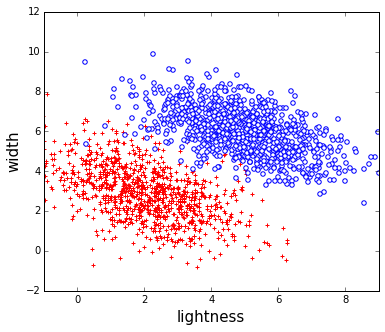

In [26]:
plot_data(c1,c2);

Primeiramente, vamos dividir a base de dados em treinamento/validação e teste

In [27]:
N = data_x.shape[0]

indices = np.arange(N)
np.random.shuffle(indices)

last_train_indice = int(0.8 * N) # 80% para treinamento, 10% para validação, 10% para teste
last_val_indice = int(0.9 * N)

train_indices = indices[0:last_train_indice]
val_indices = indices[last_train_indice: last_val_indice]
test_indices = indices[last_val_indice:]

x_train, y_train = data_x[train_indices], data_y[train_indices]
x_val, y_val = data_x[val_indices], data_y[val_indices]
x_test, y_test = data_x[test_indices], data_y[test_indices]

### Definição do modelo

O modelo logístico retorna predições usando a seguinte equação:

$$ \hat{y} =  \sigma(\textbf{w}^\intercal\textbf{x} + b)$$

Vamos primeiro definir os valores iniciais para $\textbf{w}$ e $b$:
$$\textbf{w} \sim U(-0.001, 0.001) $$

$$b = 0$$

Onde U(a,b) retorna números aleatórios segundo uma distribuição uniforme entre $[a,b]$

In [28]:
w_init = np.random.uniform(-0.001,0.001, size=(2)).astype(np.float32)
b_init = np.cast[np.float32](0)

### Exercício

Nesse exercício, o objetivo é construir uma expressão simbólica que compute $\hat{y}$. Vamos implementar esse cálculo para todos os exemplos da base de dados ao mesmo tempo, usando operações de matrizes. 

Nesse caso, consideramos como entrada uma matrix $X$, onde cada linha da matriz possui um exemplo (portanto, ela possui tamanho Nx2, onde N é o número de exemplos).

Usando essa notação, podemos calcular $\hat{y}$ para todos os vetores de entrada usando a seguinte expressão:
$$\textbf{z} = X\textbf{w} + b$$
$$ \hat{\textbf{y}} =  \sigma(\textbf{z})$$


onde 
$$\sigma(z) = \frac{1}{1 + e^{-z}}$$
Para tanto, é necessário:
 * Definir as variáveis simbólicas $x$ (matrix), $w$ (vetor) e $b$ (escalar)
     * Note que $w$ e $b$ são variáveis compartilhadas,
 * Implementar as expressões acima para computar $\textbf{z}$ e $\hat{\textbf{y}}$ 

In [ ]:
#Sua solução:

x = 
w = 
b = 

z =
y_hat = 

In [30]:
#Execute essa célula para ver a resposta

%load solutions/theano_yhat.py

### Exercício

O próximo passo é implementar a função de custo:

$$L = -\frac{1}{N} \sum_{i=1}^N{y^{(i)} \log\hat{y}^{(i)}  + (1-y^{(i)}) \log(1 - \hat{y}^{(i)}) }$$

Para tanto, é preciso:

* Definir a variável simbólica $y$ (que irá conter a classe correta, de acordo com a base de dados)
* Implementar a função de custo 


Dica: As operações aritméticas (soma, multiplicação, logaritmo), se aplicadas em um vetor, são executadas individualmente para cada elemento do vetor. É possível implementar a função acima sem nenhum loop:

```
loss = (codigo para calcular o custo para cada elemento)
loss = loss.mean()  
```

In [ ]:
#Sua solução:

y = 
loss = 

In [32]:
#Execute essa célula para ver a resposta

%load solutions/theano_loss.py

### Exercício

Para treinarmos o modelo, precisamos calcular a derivada parcial da função de custo referente à cada parametro do modelo. 

Use a função T.grad para calcular a derivada do custo relativo às variáveis $w$ e $b$

In [133]:
#Sua solução:

w_grad = 
b_grad = 

In [34]:
#Execute essa célula para ver a resposta

%load solutions/theano_grad.py

Vamos também calcular a taxa de acerto do modelo:

Consideramos que o modelo prevê $y=1$ se a saída $\hat{y} > 0.5$ e $y=0$ caso contrário

In [35]:
prediction = T.ge(y_hat, 0.5)
accuracy = T.eq(prediction, y).mean()

Por fim, vamos compilar a função que fará o treinamento.

Seguindo o algoritmo de descida de gradiente, faremos a atualização dos parâmetros de acordo com a regra:
$$ w = w - \alpha \nabla_w L$$

onde $\alpha$ é o tamanho do passo (também conhecido como Learning Rate).

Ao compilarmos uma função do Theano, podemos passar uma lista de expressões a serem atualizadas, da seguinte forma:

```
updates = [
   (variavel, novo_valor),
   ...
]
```

Dessa forma, a cada chamada da função, os valores de saída serão retornados **e** as variáveis serão atualizadas

In [36]:
alpha = theano.shared(np.cast[np.float32](0.1))

updates = [
    (w, w - alpha  * w_grad),
    (b, b - alpha * b_grad)
]

train_fn = theano.function([x, y], [loss, accuracy], updates = updates)
val_fn = theano.function([x, y], [loss, accuracy])

Dessa forma, com a função de treinamento compilada, basta iterativamente chamá-la com os valores de $X$ e $y$ da base de treinamento, e os valores de $\textbf{w}$ e $b$ serão automaticamente atualizados a cada chamada

## Visualizando a fronteira de decisão com os parametros iniciais

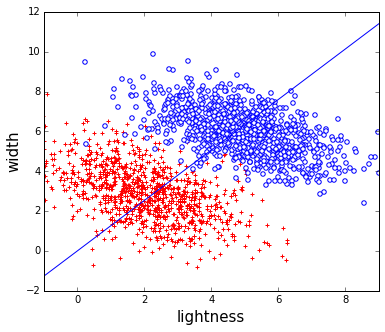

In [37]:
plot_decision_boundary(c1,c2, w.get_value(),b.get_value())

In [38]:
cost_history = []
acc_history = []
val_cost_history = []
val_acc_history = []

### Executando o treinamento por 50 iterações:

In [39]:
for i in range(50):
    cost, acc = train_fn(x_train,y_train)
    cost_history.append(cost)
    acc_history.append(acc)
    
    val_cost, val_acc = val_fn(x_val, y_val)
    val_cost_history.append(val_cost)
    val_acc_history.append(val_acc)

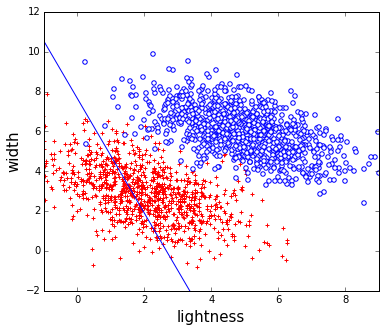

In [40]:
plot_decision_boundary(c1,c2, w.get_value(), b.get_value())

### Executando o treinamento por mais 3000 iterações:

In [41]:
for i in range(3000):
    cost, acc = train_fn(x_train,y_train)
    cost_history.append(cost)
    acc_history.append(acc)
    
    val_cost, val_acc = val_fn(x_val, y_val)
    val_cost_history.append(val_cost)
    val_acc_history.append(val_acc)

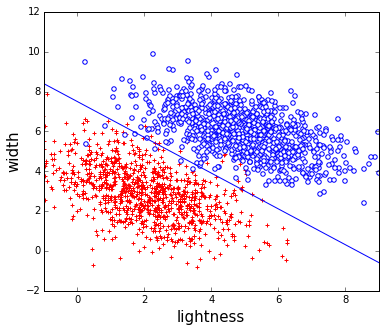

In [42]:
plot_decision_boundary(c1,c2, w.get_value(), b.get_value())

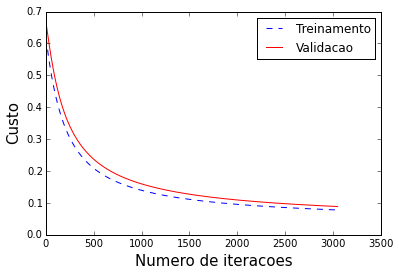

In [43]:
plt.plot(cost_history, 'b--', label='Treinamento')
plt.plot(val_cost_history, 'r-', label='Validacao')
plt.xlabel('Numero de iteracoes', fontsize=15)
plt.ylabel('Custo', fontsize=15)
plt.legend()

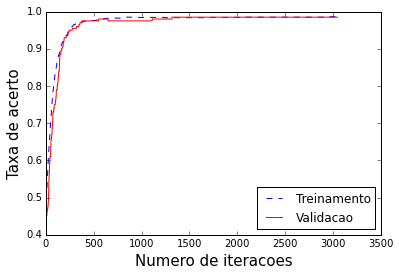

In [44]:
plt.plot(acc_history, 'b--', label='Treinamento')
plt.plot(val_acc_history, 'r-', label='Validacao')
plt.xlabel('Numero de iteracoes', fontsize=15)
plt.ylabel('Taxa de acerto', fontsize=15)
plt.legend(loc=4)

In [45]:
get_preds = theano.function([x], y_hat)

In [46]:
test_acc = np.mean((get_preds(x_test) > 0.5) == y_test)

In [47]:
print 'Acerto na base de teste: ', test_acc

Acerto na base de teste:  0.98
